# Bayesian differential abundance testing

The paper of [Kruschke (2013)](https://www.ncbi.nlm.nih.gov/pubmed/22774788) will be helpful before reading on. We used a similar approach to estimate whether there is a difference in the mean $\mu$ and the standard deviation $\sigma$ in that underly the distribution of the 130 genus level bacterial abudnances. We tried different approaches to model bacterial abundances and decided to use this approach because it remains easily interpretable and captures well the mean and standard deviation. Where it comes short is that it cannot model the skew well, which is present despite transforming the outcome. So, we can use it to answer questions like: "Do the means and the standard deviations differ between groups". To use the same notation as Kruschke, we can write the model where we have 4 groups (*home_pre* (1), *home_post* (2), *cc_pre* (3), *cc_post* (4) like this:  

$$y_{1i} \sim T(\nu, \mu_1, \sigma_1)$$  
$$y_{2i} \sim T(\nu, \mu_2, \sigma_2)$$  
$$y_{3i} \sim T(\nu, \mu_3, \sigma_3)$$  
$$y_{4i} \sim T(\nu, \mu_4, \sigma_4)$$ 

Alternatively, we can write:  
$$y_{i} \sim T(\nu, \mu, \sigma)$$ 

We model $\mu$ and $\sigma$ each as a linear function:  
$$\mu_i = \beta_{0i[j]} + \beta_{1} \times group + \beta_{2} \times time + \beta_{3} \times group \times time + \beta_{4} \times age + \beta_{5} \times breastfeeding + \beta_{6} \times sibling + \beta_{7} \times csection + \beta_{8} \times sibling \times csection$$   
$$\sigma_i = \beta_{\sigma 0} + \beta_{\sigma 1} \times group + \beta_{\sigma 2} \times time$$ 

The *j* in $\beta_{0i[j]}$ indicates that each subject can deviate from the overall mean but the individual mean is partially pooled an dragged towads the overall mean. The model will estimate the standard deviation around the overall mean and this gives some insight in individual variation among the infants. The prior specification is explained further below. We chose to include csection in the model because at that age it can have a strong influence on bacterial composition. Since 6 samples are from infants that were born via c-section in the home group as opposed to 12 samples from the cc group, we will compare the cc to home among those infants who are not born via c-section.

In [3]:
library(tidyverse)
library(glue)
library(brms)
library(furrr)
library(here)
library(future)
library(tidybayes)
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [4]:
load(here("rdata/data_mi.rds"))

## Prior specification
BRMS has reasonable standard prior specifications that can be checked as shown below. We deviated from that and applied a normal prior $N(0, 1)$ for all $\beta_i$. This way most probability is at the effect being 0 while all realistic effect size are considered by the model. This way we make the model more conservative compared to classic methods. See Gelman why this helps limit type S errors. Also we restrict how much $\sigma$ can vary between groups for each of the 3 coefficients but not for the intercept. Note that sigma is fit on the log scale automatically in brms and there again all realistic differences in this paramter that are naturally present in a similar population or that could arise from going in to CC vs HOME are considered. Finally, the prior on $\nu$ is a bit more constrained in the higher values than the standard prior. That helps the model to not consider very high $\nu$, which it would if the distribution is close to normal because then many $\nu$ are equally likely.

In [43]:
# define the formula we use at the example of Bifidobacterium
formula_mu <- glue("Bifidobacterium ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
formula_sigma <- sigma ~ 1 + time*cc + sibling*csection
formula <- bf(formula_mu, formula_sigma)
# see default priors brms
get_prior(formula, data = data_imp[[1]], family = student)
# we use default prior except for using a normal(0, 1) prior for the b
# which makes the model more skeptical of large effect sizes

prior               class     coef               group      resp dpar  nlpar
1  student_t(3, 7, 10) Intercept                                               
2                      b                                                       
3                      b         age_d_s                                       
4                      b         bf_count_s                                    
5                      b         ccyes                                         
6                      b         csection1                                     
7                      b         sibling1                                      
8                      b         sibling1:csection1                            
9                      b         timepost                                      
10                     b         timepost:ccyes                                
11 gamma(2, 0.1)       nu                                                      
12 student_t(3, 0, 10) sd                                                      
13                     sd                           subject_id                 
14                     sd        Intercept          subject_id                 
15 student_t(3, 0, 10) Intercept                                    sigma      
16                     b                                            sigma      
17                     b         ccyes                              sigma      
18                     b         csection1                          sigma      
19                     b         sibling1                           sigma      
20                     b         sibling1:csection1                 sigma      
21                     b         timepost                           sigma      
22                     b         timepost:ccyes                     sigma      
   bound
1       
2       
3       
4       
5       
6       
7       
8       
9       
10      
11      
12      
13      
14      
15      
16      
17      
18      
19      
20      
21      
22

In [711]:
# vector for genera to present
core <- c(
    "Bifidobacterium", 
    "Enterococcus", 
    "Streptococcusbovisetrel", 
    "Streptococcusmitisetrel", 
    "Streptococcusintermediusetrel",
    "Granulicatella"
)

In [ ]:
# the rest of models were fitted in cloud using same fitting function
models <- map(core, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    
})

In [6]:
# vector of genus names
genera <- colnames(data_imp[[1]])[29:158]

In [9]:
# extract mu for all genera
exclude_vector <- c()
plinps <- map(genera, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    
    # create a grid so we can get the mu for each subgroup
    nd <- with(data_imp[[1]], 
               expand.grid(cc = levels(cc), time = levels(time),
                           sibling = levels(sibling), csection = levels(csection)))
    # we use median value for bf
    nd$bf_count_s <- median(model.frame(fit)$bf_count_s)
    # it makes no sense that age remains similar when changing pre to post
    # so we use the median for pre and post
    nd <- nd %>% mutate(age_d_s = ifelse(time == "pre", -0.835, 0.626))
    
    # only add mu for genera if diagnostics are OK
    if (return_diag(fit, genus)) {
        plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
        colnames(plinp) <- c(
            "home_pre_nosib_nocsec",
            "cc_pre_nosib_nocsec",
            "home_post_nosib_nocsec",
            "cc_post_nosib_nocsec",
            "home_pre_sib_nocsec",
            "cc_pre_sib_nocsec",
            "home_post_sib_nocsec", 
            "cc_post_sib_nocsec",
            "home_pre_nosib_csec",
            "cc_pre_nosib_csec", 
            "home_post_nosib_csec",
            "cc_post_nosib_csec",
            "home_pre_sib_csec",
            "cc_pre_sib_csec",
            "home_post_sib_csec",
            "cc_post_sib_csec")
        return(plinp)
          
    } else {
        print(glue("{genus} excluded (diagnostics)"))
        exclude_vector <- c(exclude_vector, genus)
        return(NA)
    }
})

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”Warning message:
“There were 30 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Bryantellaformatexigensetrel has 30 divergent transitions


Bryantellaformatexigensetrel excluded (diagnostics)


Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Clostridiumsensustricto has 4 divergent transitions


Clostridiumsensustricto excluded (diagnostics)


Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Collinsella has 1 divergent transitions


Collinsella excluded (diagnostics)


Warning message:
“There were 25 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Escherichiacolietrel has 25 divergent transitions


Escherichiacolietrel excluded (diagnostics)


Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Eubacteriumhalliietrel has 2 divergent transitions


Eubacteriumhalliietrel excluded (diagnostics)


Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Klebisiellapneumoniaeetrel has 4 divergent transitions


Klebisiellapneumoniaeetrel excluded (diagnostics)


Warning message:
“There were 30 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Ruminococcusobeumetrel has 30 divergent transitions


Ruminococcusobeumetrel excluded (diagnostics)


Warning message:
“There were 51 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Serratia has 51 divergent transitions


Serratia excluded (diagnostics)


Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Vibrio has 2 divergent transitions


Vibrio excluded (diagnostics)


In [10]:
exclude_vector

NULL

In [22]:
# 9 models excluded
comp_plinps <- plinps[!is.na(plinps)]
exclude_vector <- c(
    "Bryantellaformatexigensetrel", 
    "Clostridiumsensustricto", 
    "Collinsella", 
    "Escherichiacolietrel", 
    "Eubacteriumhalliietrel", 
    "Klebisiellapneumoniaeetrel", 
    "Ruminococcusobeumetrel",
    "Serratia",
    "Vibrio"
)

In [29]:
# extract sigma for all genera
sigma_group <- map(genera[!genera %in% exclude_vector], function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    posterior_samples(fit) %>%
        mutate(
            home_pre = b_sigma_Intercept,
            home_post = (b_sigma_Intercept + b_sigma_timepost),
            cc_pre = (b_sigma_Intercept + b_sigma_ccyes),
            cc_post= (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + `b_sigma_timepost:ccyes`)) %>%
    mutate_if(is.numeric, exp) %>%
    mutate(
            # sigma diff
            ccpost_homepost = cc_post - home_post,
            ccpost_ccpre = cc_post - cc_pre,
            homepost_homepre = home_post - home_pre, 
            ccpre_homepre = cc_pre - home_pre,

            # store genus
            genus = genus

        ) %>%
            
            mutate_if(is.numeric, round, 2) %>%
            select(genus, ccpre_homepre, ccpost_homepost, ccpost_ccpre, homepost_homepre)

})

In [36]:
# comparisons 
comparisons <- map2(comp_plinps, genera[!genera %in% exclude_vector], function(df, genus) {
    comparisons <- df %>%
        mutate(
            genus = genus, 
            
            # ccpre vs homepre (without csec)
            homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
            ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
            ccpre_homepre = ccpre - homepre,
            
            # ccpost vs ccpre
            ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
            ccpost_ccpre = ccpost -ccpre,
            
            # ccpost vs homepost
            homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
            ccpost_homepost = ccpost - homepost,
            
            # homepost vs homepre
            homepost_homepre = homepost - homepre,
            
            # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
            nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
            sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
            sib_nosib = sib - nosib,
            
            # csec
            nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                      home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
            csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                      home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
            csec_nocsec = csec - nocsec,
            
            # sib * csec
            csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
            csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
            csecsib_csecnosib = csec_sib - csec_nosib
        ) %>%
    select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)
})
comparisons <- map_dfr(comparisons, bind_rows)

In [38]:
# nest by comparison
comparisons_nest <- comparisons %>% 
    gather(comparison, value, -genus) %>%
    group_by(comparison) %>%
    nest()

effects <- map2(comparisons_nest$data, comparisons_nest$comparison, function(df, comparison) {
    df %>% 
    group_by(genus) %>%
    summarise(
        median = median(value),
        lower = hpdi(value)[1],
        upper = hpdi(value)[2],
        prob = mean(value < 0)
    ) %>%
    #filter(lower > 0 | upper < 0) %>%
    mutate_if(is.numeric, round, 2) %>%
    arrange(desc((abs(median)))) %>%
    head(5)
})

In [39]:
# slopes of age and bf
slopes <- map(genera, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/bayesian_student/student_{genus}"))
    ) 
    posterior_samples(fit) %>%
        select(b_age_d_s, b_bf_count_s)
    })

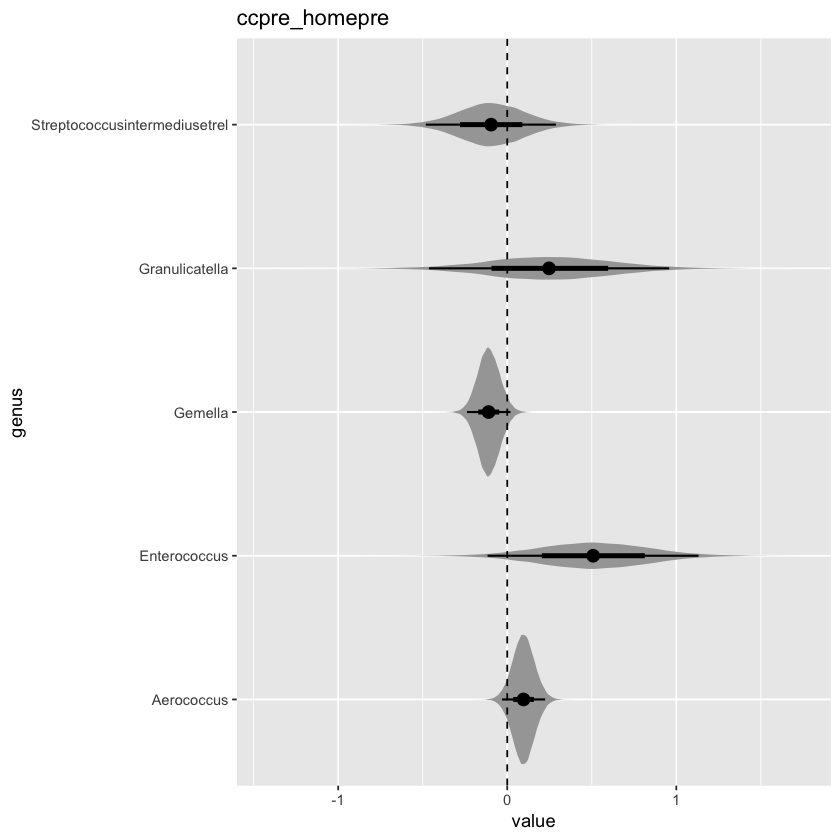

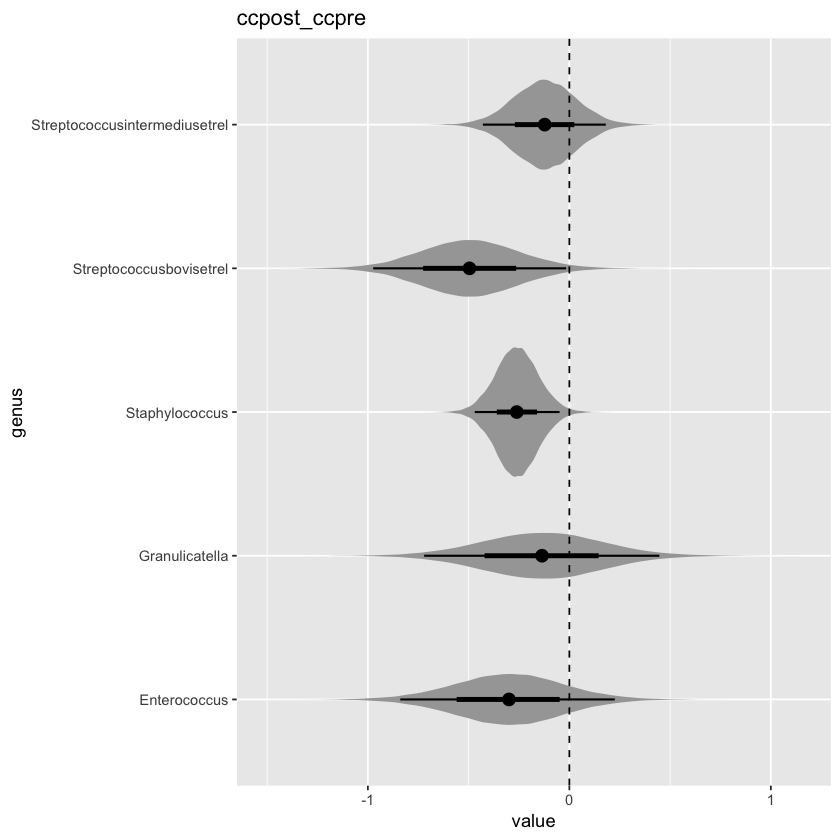

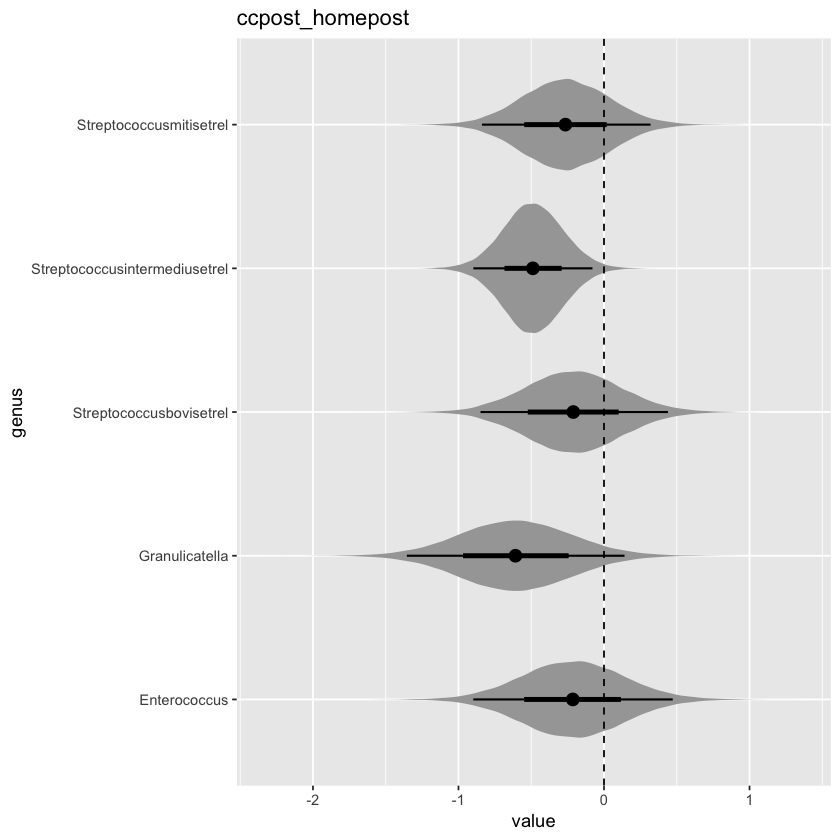

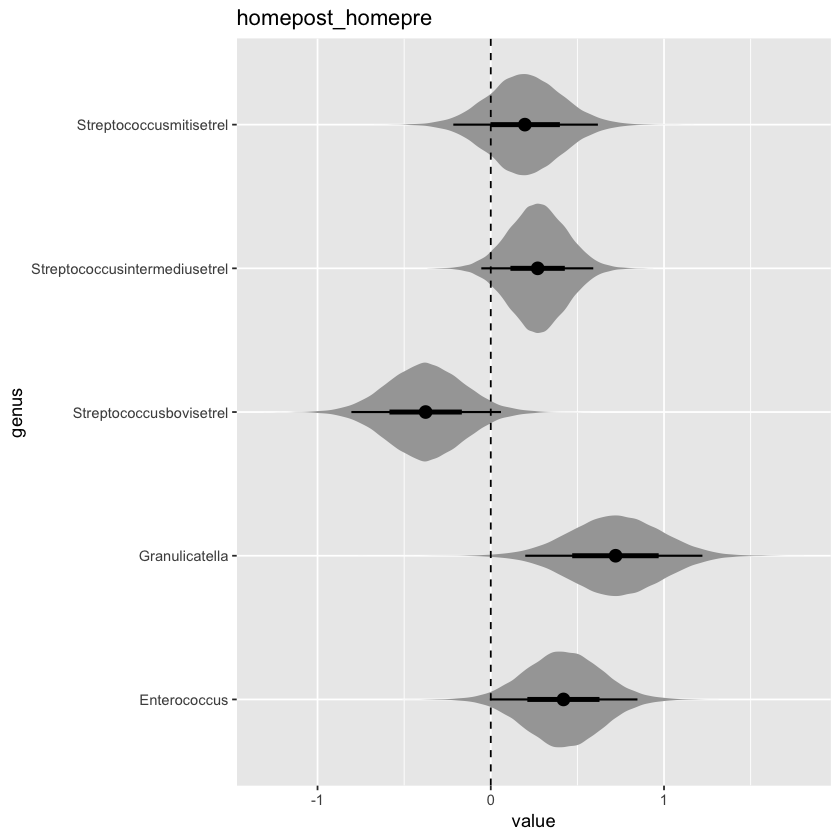

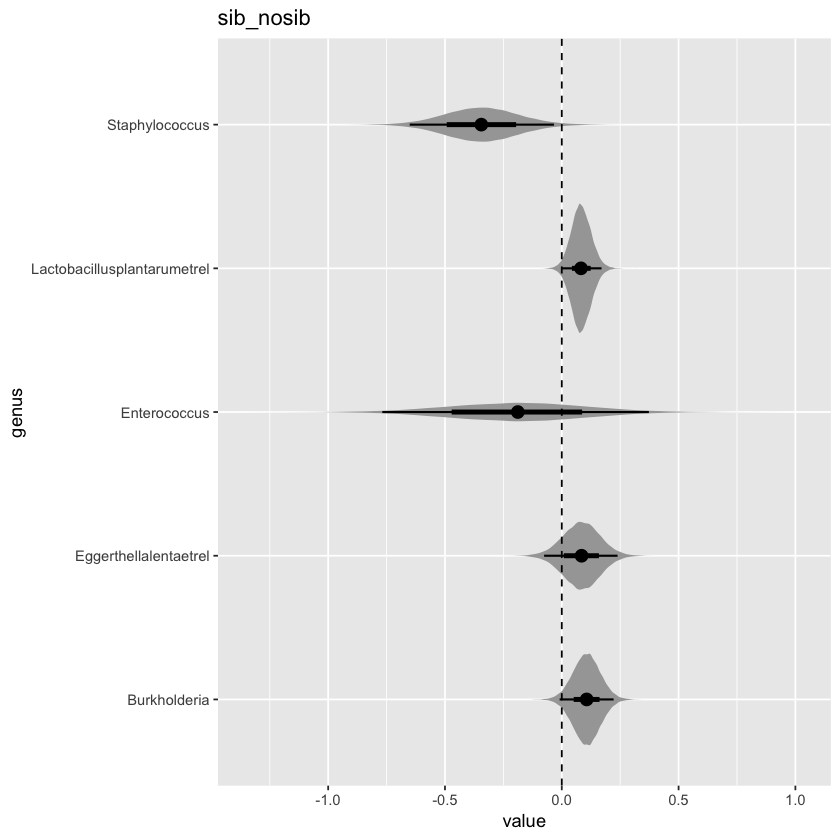

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


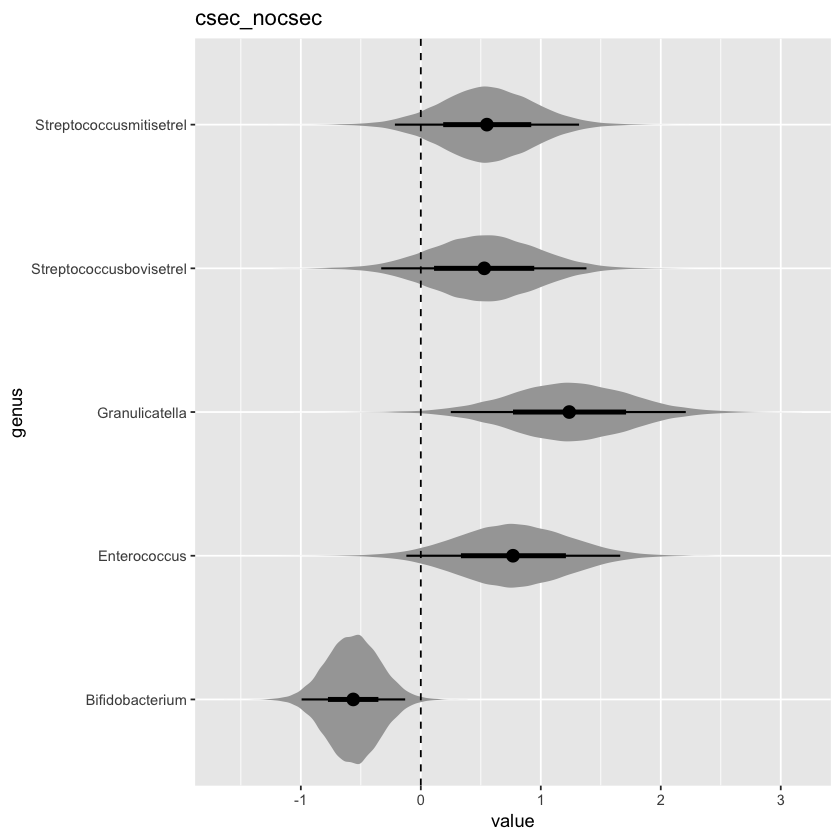

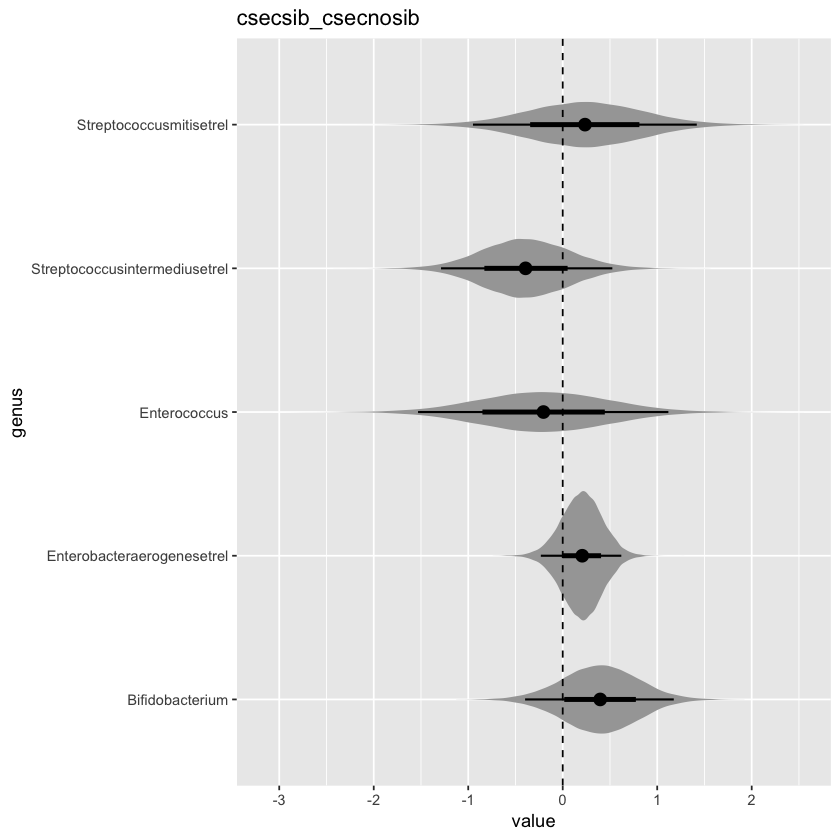

In [40]:
# for each comparison show mu_diff posterior distribution
map2(effects, comparisons_nest$comparison, function(df, comp) {
   comparisons %>% 
    gather(comparison, value, -genus) %>%
    filter(comparison == comp, genus %in% df$genus) %>%
    ggplot(aes(value, genus)) +
    geom_eyeh() +
    geom_vline(aes(xintercept = 0), linetype = "dashed") +
    ggtitle(comp)
})

    

In [41]:
comparisons %>% head()

genus            ccpre_homepre ccpost_ccpre ccpost_homepost homepost_homepre
1 Actinomycetaceae  0.04946396   -0.009640476 0.09008215      -0.05025866     
2 Actinomycetaceae  0.04146663    0.006165717 0.10429752      -0.05666517     
3 Actinomycetaceae  0.04158475   -0.013772613 0.06641222      -0.03860008     
4 Actinomycetaceae -0.01593554    0.030086970 0.04983149      -0.03568006     
5 Actinomycetaceae  0.03119072    0.006698462 0.13003299      -0.09214380     
6 Actinomycetaceae -0.00408262    0.058579523 0.13597077      -0.08147386     
  sib_nosib    csec_nocsec csecsib_csecnosib
1  0.007899619 -0.1535770  0.19385376       
2 -0.015004416 -0.1357263  0.09360933       
3 -0.023563619 -0.1418916  0.13959683       
4 -0.014878833 -0.1282724  0.04414986       
5 -0.015074814 -0.2101740  0.07546654       
6  0.008783216 -0.1671788  0.08816834

In [45]:
slopes[1]

[[1]]
          b_age_d_s  b_bf_count_s
1     -5.328413e-02 -3.356222e-02
2     -6.187267e-02 -6.676460e-03
3     -4.260079e-02 -2.213691e-02
4     -3.756119e-02  1.624984e-02
5     -4.115510e-02 -4.697668e-03
6     -4.154306e-02 -1.783880e-02
7     -4.044959e-02 -2.422217e-03
8     -4.903092e-02 -9.913270e-03
9     -1.544018e-02 -3.170032e-02
10    -2.960930e-02 -3.480273e-02
11    -1.887737e-02 -2.198435e-02
12    -4.415930e-02 -6.900407e-03
13    -1.296665e-01  8.511903e-03
14    -1.256807e-01  2.078422e-04
15    -1.236902e-02 -1.101444e-02
16     1.493084e-02 -7.846937e-03
17     3.336905e-02 -1.699089e-02
18     2.942438e-02 -3.041519e-02
19     2.181814e-02 -3.018368e-02
20     8.759153e-03 -2.221147e-03
21     1.251171e-02 -2.802754e-03
22     3.552088e-03 -2.910656e-02
23    -1.024529e-02 -1.549309e-02
24    -9.715315e-02  3.083370e-03
25    -6.822172e-02 -1.516413e-03
26    -7.074995e-03  1.337475e-02
27    -3.983763e-02 -1.492310e-02
28    -3.268274e-02  1.106981e-02
29    -5.943750e-02 -2.084554e-02
30    -1.600505e-01 -2.436647e-02
31    -7.920588e-02 -2.711656e-02
32    -6.045227e-02 -1.425085e-02
33    -5.946934e-02 -1.091855e-02
34    -3.037688e-02 -3.849181e-02
35    -5.943958e-02  1.280393e-03
36    -2.950462e-02 -1.915867e-02
37    -2.487561e-02 -1.672670e-02
38    -5.285007e-03  1.597361e-02
39     6.486230e-03 -2.388948e-02
40     1.174881e-02 -1.455224e-02
41     2.310875e-02 -1.068847e-02
42    -3.585495e-02 -4.011894e-03
43    -2.106122e-02 -2.018978e-02
44    -1.464165e-04 -2.125159e-03
45    -4.368608e-02 -1.655295e-02
46    -5.141788e-02 -3.141521e-03
47    -5.287507e-02 -2.523389e-02
48    -5.618028e-02 -8.010457e-03
49    -2.942126e-02 -3.519955e-03
50    -6.997744e-02  2.895957e-02
51    -4.479606e-02  1.257410e-02
52    -8.199696e-03 -2.524371e-03
53    -3.935262e-03 -6.553063e-03
54    -2.017553e-02 -4.901332e-03
55    -2.129156e-02 -1.316392e-04
56    -4.266075e-02  7.157443e-03
57    -1.485586e-02  7.982427e-04
58     2.796239e-03  1.369317e-02
59    -3.096073e-02 -9.854245e-03
60    -4.954948e-02  1.343827e-02
61    -1.674369e-02 -4.305917e-03
62    -2.806689e-02 -9.098690e-03
63    -2.042177e-02 -2.308634e-03
64    -8.269262e-02  6.463825e-03
65    -3.329953e-02 -9.770651e-03
66    -7.237732e-02 -6.269429e-03
67    -1.784631e-02 -7.545840e-03
68    -3.096969e-02 -1.260866e-02
69    -4.493227e-02 -3.883799e-02
70    -3.220616e-02  1.394836e-02
71    -2.895955e-02  9.923216e-03
72    -3.113647e-02  1.399839e-02
73    -5.046400e-02 -2.573276e-02
74    -6.549930e-02 -4.130605e-03
75    -7.111075e-02  2.618957e-02
76    -6.487120e-02  2.071541e-02
77    -1.742699e-02 -3.669871e-03
78    -2.763897e-02  1.841320e-02
79    -4.040435e-02  1.705341e-03
80     7.919885e-03  2.437193e-02
81    -2.627806e-02  2.880569e-03
82    -6.586377e-04  1.959190e-03
83    -1.013771e-02 -2.753413e-02
84    -4.555681e-02  1.601164e-02
85    -4.166911e-02 -7.379942e-03
86    -2.340371e-02 -3.747232e-02
87    -2.726773e-03 -3.175885e-03
88     1.604315e-02  1.723576e-02
89    -2.742241e-02 -3.005495e-03
90    -3.403966e-02 -4.637051e-03
91    -4.279456e-02 -1.724085e-02
92    -4.659036e-02 -1.712203e-02
93    -7.967814e-02 -1.623792e-02
94    -4.064902e-02  2.377007e-02
95    -4.816270e-02  3.018387e-02
96    -5.735482e-02  1.524874e-02
97    -3.471443e-02 -9.192547e-03
98    -4.347645e-02  1.863943e-02
99    -6.798403e-02  2.160134e-03
100   -2.521289e-02  2.351707e-03
101   -6.743756e-02  1.528813e-02
102   -7.464290e-02 -1.956666e-02
103   -8.168996e-02  6.191198e-03
104   -6.159370e-02  9.225196e-03
105   -4.283371e-02  1.067671e-02
106   -3.684460e-02 -2.490552e-02
107   -5.446143e-02 -2.495705e-02
108   -4.316992e-02 -2.027573e-03
109   -1.061579e-01  9.751384e-03
110   -7.744730e-02 -1.605655e-02
111   -2.655986e-03 -2.943165e-02
112   -2.344312e-02 -2.714296e-03
113   -7.335769e-02 -8.304835e-03
114   -3.284293e-03  1.211093e-02
115   -4.597963e-03 -2.879821e-02
116   -6.243824e-03 -3.425009e-02
117   -4.514945e

In [49]:
# fit example model
test <- brm_multiple(
    data = data_imp,
    family = student(),
    formula = bf(formula_mu, formula_sigma),
    prior = c(prior(normal(0, 1), class = b),
              prior(normal(0, 4), class = Intercept, dpar = sigma),
              prior(normal(0, 0.2), class = b, dpar = sigma), 
              prior(gamma(2, 0.2), class = nu)),
    cores = 4,
    file = here(glue("models/bayesian_student/student_Bifidobacterium_test"))
) 
test2 <- brm_multiple(
    data = data_imp,
    family = student(),
    formula = bf(formula_mu, formula_sigma),
    prior = c(prior(normal(0, 1), class = b),
              prior(normal(0, 4), class = Intercept, dpar = sigma),
              prior(normal(0, 0.2), class = b, dpar = sigma), 
              prior(gamma(2, 0.2), class = nu)),
    cores = 4,
    file = here(glue("models/bayesian_student/student_Bifidobacterium"))
)

In [57]:
genus = "Bifidobacterium"
posterior_samples(test) %>%
    mutate(
    # homepre
    home_pre_nosib_nocsec = b_sigma_Intercept,
    home_pre_nosib_csec = (b_sigma_Intercept + b_sigma_csection1),
    home_pre_sib_nocsec = (b_sigma_Intercept + b_sigma_sibling1),
    home_pre_sib_csec = (b_sigma_Intercept + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
    homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,

    # homepost
    home_post_nosib_nocsec = (b_sigma_Intercept + b_sigma_timepost),
    home_post_nosib_csec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_csection1),
    home_post_sib_nocsec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_sibling1),
    home_post_sib_csec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
    homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,

    # ccpre
    cc_pre_nosib_nocsec = (b_sigma_Intercept + b_sigma_ccyes),
    cc_pre_nosib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_csection1),
    cc_pre_sib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_sibling1),
    cc_pre_sib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
    ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,

    # ccpost
    cc_post_nosib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost),
    cc_post_nosib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_csection1),
    cc_post_sib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_sibling1),
    cc_post_sib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
    ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,

    # csection
    nocsec = (cc_post_sib_csec + cc_post_nosib_csec + cc_pre_sib_csec + cc_pre_nosib_csec + home_post_sib_csec + home_post_nosib_csec + home_pre_sib_csec + home_pre_nosib_csec)/8,
    csec = (cc_post_sib_nocsec + cc_post_nosib_nocsec + cc_pre_sib_nocsec + cc_pre_nosib_nocsec + home_post_sib_nocsec + home_post_nosib_nocsec + home_pre_sib_nocsec + home_pre_nosib_nocsec)/8,

    # siblings 
    sib = (home_pre_sib_csec + home_pre_sib_nocsec + home_post_sib_csec + home_post_sib_nocsec + cc_pre_sib_csec + cc_pre_sib_nocsec + cc_post_sib_csec + cc_post_sib_nocsec)/8,
    nosib = (home_pre_nosib_csec + home_pre_nosib_nocsec + home_post_nosib_csec + home_post_nosib_nocsec + cc_pre_nosib_csec + cc_pre_nosib_nocsec + cc_post_nosib_csec + cc_post_nosib_nocsec)/8) %>%
    mutate_if(is.numeric, exp) %>%
    mutate(
    # sigma diff
    ccpost_homepost = ccpost - homepost,
    ccpost_ccpre = ccpost - ccpre,
    homepost_homepre = homepost - homepre, 
    ccpre_homepre = ccpre - homepre,
    sib_nosib = sib - nosib, 
    csec_nocsec = csec - nocsec,

    # store genus
    genus = genus) %>%
    select(genus, ccpost_homepost, ccpost_ccpre, homepost_homepre, ccpre_homepre, sib_nosib, csec_nocsec)

genus           ccpost_homepost ccpost_ccpre  homepost_homepre
1     Bifidobacterium -0.0392004897    0.0099424298  0.0117884149   
2     Bifidobacterium  0.0730248644   -0.0777852023 -0.0592465800   
3     Bifidobacterium  0.0221167029   -0.0087769178 -0.0082077404   
4     Bifidobacterium  0.0520376219   -0.0523530932 -0.0428938085   
5     Bifidobacterium -0.0410351510    0.0241514101  0.0277108546   
6     Bifidobacterium -0.0585093936   -0.0068694608 -0.0082629967   
7     Bifidobacterium  0.1108878097    0.0425480459  0.0299169417   
8     Bifidobacterium  0.0191123570    0.0231695890  0.0215220815   
9     Bifidobacterium  0.0302427103   -0.0338496724 -0.0305789772   
10    Bifidobacterium  0.0005303914    0.0256549819  0.0256007250   
11    Bifidobacterium -0.0441545434    0.0041849387  0.0049328503   
12    Bifidobacterium  0.0788061596   -0.0412379124 -0.0293442509   
13    Bifidobacterium -0.0681460687    0.0082220899  0.0106076656   
14    Bifidobacterium  0.0925633455   -0.0165445625 -0.0109891674   
15    Bifidobacterium  0.0528823583   -0.0491931013 -0.0374076774   
16    Bifidobacterium  0.0175169625   -0.0036717863 -0.0034465092   
17    Bifidobacterium  0.0541959945   -0.0573044210 -0.0471302405   
18    Bifidobacterium  0.0600293902   -0.0827789190 -0.0616597896   
19    Bifidobacterium  0.0533621650   -0.0977701740 -0.0752274435   
20    Bifidobacterium -0.0212776602   -0.0309055400 -0.0329824812   
21    Bifidobacterium -0.0039779447   -0.0063359495 -0.0064307622   
22    Bifidobacterium  0.0069721845   -0.0697646042 -0.0678150274   
23    Bifidobacterium  0.0371943630   -0.0642152421 -0.0541740172   
24    Bifidobacterium  0.0080144977    0.0349829199  0.0337297451   
25    Bifidobacterium  0.0673784086    0.0139289460  0.0105516111   
26    Bifidobacterium -0.0042168089    0.0148001799  0.0149678668   
27    Bifidobacterium  0.0954139184    0.0732837869  0.0514851071   
28    Bifidobacterium -0.0105334476   -0.0163679473 -0.0171191065   
29    Bifidobacterium  0.0799058478    0.0003493976  0.0002449602   
30    Bifidobacterium  0.0207341538   -0.0683391623 -0.0637318942   
⋮     ⋮               ⋮               ⋮             ⋮               
39971 Bifidobacterium  0.045320479    -0.040843110  -0.034290074    
39972 Bifidobacterium  0.035980793    -0.034766541  -0.031288654    
39973 Bifidobacterium  0.005814534    -0.070326982  -0.069120600    
39974 Bifidobacterium  0.021590816     0.036601346   0.034737484    
39975 Bifidobacterium  0.033660296    -0.093800655  -0.083234601    
39976 Bifidobacterium  0.010910997     0.016438848   0.015856383    
39977 Bifidobacterium  0.066703301    -0.023732607  -0.018814484    
39978 Bifidobacterium  0.008888565    -0.020457427  -0.019775574    
39979 Bifidobacterium -0.013507459    -0.090423688  -0.095098171    
39980 Bifidobacterium  0.049517864     0.044939547   0.037418753    
39981 Bifidobacterium  0.042956613    -0.046383018  -0.040444715    
39982 Bifidobacterium  0.003471009     0.011307760   0.011199938    
39983 Bifidobacterium -0.029465983    -0.059552119  -0.066601241    
39984 Bifidobacterium  0.047195785     0.002813988   0.002389397    
39985 Bifidobacterium -0.057067859     0.036054929   0.041284910    
39986 Bifidobacterium  0.011328440     0.028662531   0.027621934    
39987 Bifidobacterium  0.033676967    -0.005342893  -0.004723625    
39988 Bifidobacterium  0.038524033    -0.107435495  -0.092589725    
39989 Bifidobacterium  0.088442227    -0.033508549  -0.023934336    
39990 Bifidobacterium  0.038050121    -0.001816746  -0.001609719    
39991 Bifidobacterium  0.059903194     0.004438918   0.003627675    
39992 Bifidobacterium -0.019791862     0.057315238   0.060522405    
39993 Bifidobacterium  0.062174721     0.089708921   0.073381615    
39994 Bifidobacterium  0.024858668    -0.032900584  -0.030267403    
39995 Bifidobacterium  0.065687882    -0.056427041  -0.045704435    
39996 Bifidobacterium  0.001609501    -0.050137671  -0.049911645    
3999

In [59]:
# create a grid so we can get the mu for each subgroup
nd <- with(data_imp[[1]], 
           expand.grid(cc = levels(cc), time = levels(time),
                       sibling = levels(sibling), csection = levels(csection)))
# we use median value for bf
nd$bf_count_s <- median(model.frame(test)$bf_count_s)
# it makes no sense that age remains similar when changing pre to post
# so we use the median for pre and post
nd <- nd %>% mutate(age_d_s = ifelse(time == "pre", -0.835, 0.626))
plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
colnames(plinp) <- c(
    "home_pre_nosib_nocsec",
    "cc_pre_nosib_nocsec",
    "home_post_nosib_nocsec",
    "cc_post_nosib_nocsec",
    "home_pre_sib_nocsec",
    "cc_pre_sib_nocsec",
    "home_post_sib_nocsec", 
    "cc_post_sib_nocsec",
    "home_pre_nosib_csec",
    "cc_pre_nosib_csec", 
    "home_post_nosib_csec",
    "cc_post_nosib_csec",
    "home_pre_sib_csec",
    "cc_pre_sib_csec",
    "home_post_sib_csec",
    "cc_post_sib_csec")

In [60]:
plinp

home_pre_nosib_nocsec cc_pre_nosib_nocsec home_post_nosib_nocsec
1     6.446061              6.539121            6.453140              
2     6.569799              6.654601            6.398117              
3     6.492711              6.615420            6.403505              
4     6.684361              6.662010            6.632301              
5     6.557751              6.680615            6.567679              
6     6.589908              6.634285            6.330554              
7     6.636143              6.743140            6.611160              
8     6.625498              6.664619            6.494435              
9     6.623249              6.734334            6.656238              
10    6.521191              6.639277            6.512258              
11    6.547505              6.545300            6.451526              
12    6.662362              6.737973            6.533164              
13    6.476561              6.721006            6.455234              
14    6.541813              6.581277            6.523204              
15    6.481434              6.533042            6.386547              
16    6.610108              6.610827            6.552762              
17    6.507241              6.652878            6.437119              
18    6.321768              6.601489            6.141160              
19    6.617092              6.609173            6.489007              
20    6.705024              6.503660            6.520342              
21    6.514993              6.427256            6.422110              
22    6.605962              6.553556            6.563679              
23    6.480326              6.793509            6.504530              
24    6.742801              6.567444            6.646329              
25    6.714862              6.851329            6.732075              
26    6.496069              6.654067            6.406632              
27    6.590098              6.498995            6.555580              
28    6.400250              6.530746            6.413839              
29    6.416166              6.575219            6.446063              
30    6.609668              6.842403            6.510284              
⋮     ⋮                     ⋮                   ⋮                     
39971 6.472118              6.688285            6.411761              
39972 6.735136              6.713719            6.583258              
39973 6.409387              6.692135            6.345737              
39974 6.422112              6.774885            6.420852              
39975 6.606240              6.419996            6.552012              
39976 6.608113              6.560892            6.463710              
39977 6.484851              6.528194            6.466921              
39978 6.654374              6.620900            6.568745              
39979 6.465237              6.546292            6.349674              
39980 6.633286              6.566977            6.438376              
39981 6.569672              6.779499            6.565762              
39982 6.612280              6.589636            6.652119              
39983 6.495416              6.494979            6.340161              
39984 6.460972              6.473803            6.372203              
39985 6.652125              6.649145            6.686896              
39986 6.430245              6.737194            6.368913              
39987 6.747963              6.857813            6.618055              
39988 6.667471              6.663233            6.490139              
39989 6.650163              6.691008            6.527185              
39990 6.574384              6.687037            6.629170              
39991 6.462083              6.708109            6.523702              
39992 6.508197              6.805090            6.585459              
39993 6.636589              6.666745            6.459898              
39994 6.704904              6.673989            6.685425              
39995 6.715863              6.

In [61]:
comparisons <- plinp %>%
        mutate(
            genus = genus, 
            
            # ccpre vs homepre (without csec)
            homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
            ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
            ccpre_homepre = ccpre - homepre,
            
            # ccpost vs ccpre
            ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
            ccpost_ccpre = ccpost -ccpre,
            
            # ccpost vs homepost
            homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
            ccpost_homepost = ccpost - homepost,
            
            # homepost vs homepre
            homepost_homepre = homepost - homepre,
            
            # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
            nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
            sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
            sib_nosib = sib - nosib,
            
            # csec
            nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                      home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
            csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                      home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
            csec_nocsec = csec - nocsec,
            
            # sib * csec
            csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
            csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
            csecsib_csecnosib = csec_sib - csec_nosib
        ) %>%
    select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)

In [65]:
comparisons %>% gather(comp, value, -genus) %>%
    group_by(comp) %>%
    select(-genus) %>%
    median_qi()

comp              value        .lower      .upper      .width .point
1 ccpost_ccpre       0.042515821 -0.16056234  0.23775548 0.95   median
2 ccpost_homepost    0.202545825 -0.03946076  0.45014957 0.95   median
3 ccpre_homepre      0.076945023 -0.17929124  0.33429359 0.95   median
4 csec_nocsec       -0.563229680 -0.99355373 -0.13033660 0.95   median
5 csecsib_csecnosib  0.396805564 -0.39820600  1.17524819 0.95   median
6 homepost_homepre  -0.084423553 -0.26931325  0.09561362 0.95   median
7 sib_nosib         -0.001793238 -0.22164569  0.21288769 0.95   median
  .interval
1 qi       
2 qi       
3 qi       
4 qi       
5 qi       
6 qi       
7 qi

In [80]:
BIBO <- Sys.getenv("BIBO")

In [83]:
genera <- colnames(data_imp[[1]])[29:30]

# fit models 
comparisons <- map(genera, function(genus) {
  
    # specify model
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc + sibling*csection
    formula <- bf(formula_mu, formula_sigma)
    
    # fit model
    fit <- brm_multiple(
        data = data_imp,
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = glue("{BIBO}/models/bayesian_student/student_sigma_{genus}")
    ) 
    
    # create a grid so we can get the mu for each subgroup
    nd <- with(data_imp[[1]], 
               expand.grid(cc = levels(cc), time = levels(time),
                           sibling = levels(sibling), csection = levels(csection)))
    # we use median value for bf
    nd$bf_count_s <- median(model.frame(fit)$bf_count_s)
    # it makes no sense that age remains similar when changing pre to post
    # so we use the median for pre and post
    nd <- nd %>% mutate(age_d_s = ifelse(time == "pre", -0.835, 0.626))
    
    # only add mu for genera if diagnostics are OK
    if (return_diag(fit, genus)) {
      
        # calulate mu for each subgroup
        plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
        colnames(plinp) <- c(
            "home_pre_nosib_nocsec",
            "cc_pre_nosib_nocsec",
            "home_post_nosib_nocsec",
            "cc_post_nosib_nocsec",
            "home_pre_sib_nocsec",
            "cc_pre_sib_nocsec",
            "home_post_sib_nocsec", 
            "cc_post_sib_nocsec",
            "home_pre_nosib_csec",
            "cc_pre_nosib_csec", 
            "home_post_nosib_csec",
            "cc_post_nosib_csec",
            "home_pre_sib_csec",
            "cc_pre_sib_csec",
            "home_post_sib_csec",
            "cc_post_sib_csec")
            
        # mu comparisons (csec group separately)
        mu_group <- plinp %>%
            mutate(
                genus = genus, 
                
                # ccpre vs homepre 
                homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
                ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
                ccpre_homepre = ccpre - homepre,
                
                # ccpost vs ccpre
                ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
                ccpost_ccpre = ccpost -ccpre,
                
                # ccpost vs homepost
                homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
                ccpost_homepost = ccpost - homepost,
                
                # homepost vs homepre
                homepost_homepre = homepost - homepre,
                
                # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
                nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
                sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
                sib_nosib = sib - nosib,
                
                # csec
                nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                          home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
                csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                          home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
                csec_nocsec = csec - nocsec,
                
                # sib * csec
                csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
                csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
                csecsib_csecnosib = csec_sib - csec_nosib
            ) %>%
        select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)
            
        
        
        # calculate sigma
        sigma_group <- posterior_samples(fit) %>%
          mutate(
            #
            # homepre
            home_pre_nosib_nocsec = b_sigma_Intercept,
            home_pre_nosib_csec = (b_sigma_Intercept + b_sigma_csection1),
            home_pre_sib_nocsec = (b_sigma_Intercept + b_sigma_sibling1),
            home_pre_sib_csec = (b_sigma_Intercept + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
            homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,

            # homepost
            home_post_nosib_nocsec = (b_sigma_Intercept + b_sigma_timepost),
            home_post_nosib_csec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_csection1),
            home_post_sib_nocsec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_sibling1),
            home_post_sib_csec = (b_sigma_Intercept + b_sigma_timepost + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
            homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,

            # ccpre
            cc_pre_nosib_nocsec = (b_sigma_Intercept + b_sigma_ccyes),
            cc_pre_nosib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_csection1),
            cc_pre_sib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_sibling1),
            cc_pre_sib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
            ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,

            # ccpost
            cc_post_nosib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost),
            cc_post_nosib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_csection1),
            cc_post_sib_nocsec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_sibling1),
            cc_post_sib_csec = (b_sigma_Intercept + b_sigma_ccyes + b_sigma_timepost + b_sigma_sibling1 + b_sigma_csection1 + `b_sibling1:csection1`),
            ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,

            # csection
            nocsec = (cc_post_sib_csec + cc_post_nosib_csec + cc_pre_sib_csec + cc_pre_nosib_csec + home_post_sib_csec + home_post_nosib_csec + home_pre_sib_csec + home_pre_nosib_csec)/8,
            csec = (cc_post_sib_nocsec + cc_post_nosib_nocsec + cc_pre_sib_nocsec + cc_pre_nosib_nocsec + home_post_sib_nocsec + home_post_nosib_nocsec + home_pre_sib_nocsec + home_pre_nosib_nocsec)/8,

            # siblings 
            sib = (home_pre_sib_csec + home_pre_sib_nocsec + home_post_sib_csec + home_post_sib_nocsec + cc_pre_sib_csec + cc_pre_sib_nocsec + cc_post_sib_csec + cc_post_sib_nocsec)/8,
            nosib = (home_pre_nosib_csec + home_pre_nosib_nocsec + home_post_nosib_csec + home_post_nosib_nocsec + cc_pre_nosib_csec + cc_pre_nosib_nocsec + cc_post_nosib_csec + cc_post_nosib_nocsec)/8) %>%
          mutate_if(is.numeric, exp) %>%
          mutate(
            # sigma diff
            ccpost_homepost = ccpost - homepost,
            ccpost_ccpre = ccpost - ccpre,
            homepost_homepre = homepost - homepre, 
            ccpre_homepre = ccpre - homepre,
            sib_nosib = sib - nosib, 
            csec_nocsec = csec - nocsec,

            genus = genus) %>%
          select(genus, ccpost_homepost, ccpost_ccpre, homepost_homepre, ccpre_homepre, sib_nosib, csec_nocsec)
        
        return(list(mu_group, sigma_group))
        
          
    } else {
        print(glue("{genus} excluded (diagnostics)"))
        exclude_vector <- c(exclude_vector, genus)
        return(NA)
    }
})

Fitting imputed model 1
Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 6
Fitting imputed model 7
Fitting imputed model 8
Fitting imputed model 9
Fitting imputed model 10
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Fitting imputed model 1
Compiling the C++ model
Start sampling
Fitting imputed model 2
Fitting imputed model 3
Fitting imputed model 4
Fitting imputed model 5
Fitting imputed model 6
Fitting imputed model 7
Fitting imputed model 8
Fitting imputed model 9
Fitting imputed model 10
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling
Start sampling


In [84]:
comparisons

[[1]]
[[1]][[1]]
# A tibble: 40,000 x 8
   genus ccpre_homepre ccpost_ccpre ccpost_homepost homepost_homepre sib_nosib
   <chr>         <dbl>        <dbl>           <dbl>            <dbl>     <dbl>
 1 Acti…      -0.00508      0.0281           0.136           -0.113     0.0930
 2 Acti…      -0.0301      -0.00502          0.0444          -0.0796   -0.0579
 3 Acti…      -0.0148       0.0536           0.0149           0.0238    0.0539
 4 Acti…      -0.0147       0.0679           0.0877          -0.0345    0.0803
 5 Acti…      -0.0627       0.0308           0.0458          -0.0776    0.0232
 6 Acti…       0.0109       0.0451           0.0905          -0.0345    0.0380
 7 Acti…       0.0374       0.0261           0.0929          -0.0295    0.0468
 8 Acti…       0.0219       0.0236           0.0843          -0.0388    0.0172
 9 Acti…      -0.0236       0.0636           0.106           -0.0660    0.0275
10 Acti…      -0.0333       0.0548           0.0802          -0.0587   -0.0417
# … with 39,990 more rows, and 2 more variables: csec_nocsec <dbl>,
#   csecsib_csecnosib <dbl>

[[1]][[2]]
                 genus ccpost_homepost  ccpost_ccpre homepost_homepre
1     Actinomycetaceae   -2.455338e-03 -9.887092e-03    -1.016458e-02
2     Actinomycetaceae    9.596859e-03 -2.532586e-02    -2.271495e-02
3     Actinomycetaceae    3.338589e-03 -4.967619e-02    -4.777621e-02
4     Actinomycetaceae   -1.132546e-02 -1.656490e-02    -1.926289e-02
5     Actinomycetaceae   -7.675051e-03  2.351038e-04     2.574942e-04
6     Actinomycetaceae   -2.601540e-03 -5.371239e-02    -5.597494e-02
7     Actinomycetaceae   -6.625861e-03 -2.898381e-02    -3.269949e-02
8     Actinomycetaceae    1.437526e-03 -1.479420e-02    -1.456278e-02
9     Actinomycetaceae    5.007943e-03 -4.161053e-02    -3.918410e-02
10    Actinomycetaceae    7.753956e-03 -6.967381e-03    -6.503512e-03
11    Actinomycetaceae   -6.220240e-03 -1.570345e-02    -1.686736e-02
12    Actinomycetaceae   -1.655156e-03 -3.955693e-03    -4.040855e-03
13    Actinomycetaceae    3.844589e-03 -2.027018e-02    -1.929333e-02
14    Actinomycetaceae    3.681310e-03 -4.806643e-02    -4.543384e-02
15    Actinomycetaceae    4.759616e-03 -1.174135e-02    -1.108134e-02
16    Actinomycetaceae    1.586943e-03 -2.554126e-02    -2.514249e-02
17    Actinomycetaceae    7.060126e-04 -4.504596e-02    -4.464979e-02
18    Actinomycetaceae   -5.137123e-04 -5.156354e-02    -5.189181e-02
19    Actinomycetaceae    1.391015e-02 -2.881615e-02    -2.502170e-02
20    Actinomycetaceae    2.740289e-03 -2.485795e-02    -2.421870e-02
21    Actinomycetaceae   -4.009681e-03 -1.170968e-02    -1.221288e-02
22    Actinomycetaceae    1.947649e-02 -3.933277e-02    -3.223951e-02
23    Actinomycetaceae   -4.520058e-03 -1.508203e-02    -1.575425e-02
24    Actinomycetaceae    3.482445e-02 -6.007976e-02    -4.253368e-02
25    Actinomycetaceae   -1.173678e-02 -1.712350e-02    -1.975660e-02
26    Actinomycetaceae    2.507651e-02 -1.086873e-02    -8.524292e-03
27    Actinomycetaceae    2.730132e-03 -2.073471e-02    -2.010725e-02
28    Actinomycetaceae   -1.488485e-02 -4.898010e-02    -5.902139e-02
29    Actinomycetaceae   -3.807045e-03 -2.998989e-02    -3.134849e-02
30    Actinomycetaceae    8.202874e-03 -1.766358e-02    -1.606740e-02
31    Actinomycetaceae    7.680873e-03 -4.301075e-02    -3.994676e-02
32    Actinomycetaceae    1.621399e-02 -3.989958e-02    -3.396763e-02
33    Actinomycetaceae   -2.218636e-03 -3.310572e-02    -3.411365e-02
34    Actinomycetaceae    1.330795e-02 -3.440502e-02    -3.041017e-02
35    Actinomycetaceae    1.248814e-02 -5.795714e-02    -5.006051e-02
36    Actinomycetaceae    3.697671e-03 -2.193227e-02    -2.102370e-02
37    Actinomycetaceae    2.182458e-02 -1.424039e-02    -1.186046e-02
38    Actinomycetaceae    3.660040e-03 -7.537732e-02    -7.252180e-02
39    Actinomycetaceae   -1.855800e-03 -1.624652e-02    -1.659763e-02
40    Actinomycetaceae   -1.207112e-02 -2.957622e-02    -3.354151e-02
41    Actinomycetaceae   -1.026171

In [111]:
plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0, dpar = "sigma") %>% as_tibble()
plinp2 <- fitted(fit, nd, scale = "response",  re_formula = NA, summary = F, dpar = "sigma") %>% as_tibble()
colnames(plinp) <- c(
    "home_pre_nosib_nocsec",
    "cc_pre_nosib_nocsec",
    "home_post_nosib_nocsec",
    "cc_post_nosib_nocsec",
    "home_pre_sib_nocsec",
    "cc_pre_sib_nocsec",
    "home_post_sib_nocsec", 
    "cc_post_sib_nocsec",
    "home_pre_nosib_csec",
    "cc_pre_nosib_csec", 
    "home_post_nosib_csec",
    "cc_post_nosib_csec",
    "home_pre_sib_csec",
    "cc_pre_sib_csec",
    "home_post_sib_csec",
    "cc_post_sib_csec")
colnames(plinp2) <- c(
    "home_pre_nosib_nocsec",
    "cc_pre_nosib_nocsec",
    "home_post_nosib_nocsec",
    "cc_post_nosib_nocsec",
    "home_pre_sib_nocsec",
    "cc_pre_sib_nocsec",
    "home_post_sib_nocsec", 
    "cc_post_sib_nocsec",
    "home_pre_nosib_csec",
    "cc_pre_nosib_csec", 
    "home_post_nosib_csec",
    "cc_post_nosib_csec",
    "home_pre_sib_csec",
    "cc_pre_sib_csec",
    "home_post_sib_csec",
    "cc_post_sib_csec")

In [112]:
plinp %>% summarise_all(c(mean, sd))
plinp2 %>% summarise_all(c(mean, sd))

home_pre_nosib_nocsec_fn1 cc_pre_nosib_nocsec_fn1 home_post_nosib_nocsec_fn1
1 0.2717946                 0.3013491               0.2558286                 
  cc_post_nosib_nocsec_fn1 home_pre_sib_nocsec_fn1 cc_pre_sib_nocsec_fn1
1 0.2653877                0.2717946               0.3013491            
  home_post_sib_nocsec_fn1 cc_post_sib_nocsec_fn1 home_pre_nosib_csec_fn1
1 0.2558286                0.2653877              0.2717946              
  cc_pre_nosib_csec_fn1 ⋯ home_post_sib_nocsec_fn2 cc_post_sib_nocsec_fn2
1 0.3013491             ⋯ 0.05170658               0.05988139            
  home_pre_nosib_csec_fn2 cc_pre_nosib_csec_fn2 home_post_nosib_csec_fn2
1 0.0529915               0.06144779            0.05170658              
  cc_post_nosib_csec_fn2 home_pre_sib_csec_fn2 cc_pre_sib_csec_fn2
1 0.05988139             0.0529915             0.06144779         
  home_post_sib_csec_fn2 cc_post_sib_csec_fn2
1 0.05170658             0.05988139

home_pre_nosib_nocsec_fn1 cc_pre_nosib_nocsec_fn1 home_post_nosib_nocsec_fn1
1 0.2717946                 0.3013491               0.2558286                 
  cc_post_nosib_nocsec_fn1 home_pre_sib_nocsec_fn1 cc_pre_sib_nocsec_fn1
1 0.2653877                0.2717946               0.3013491            
  home_post_sib_nocsec_fn1 cc_post_sib_nocsec_fn1 home_pre_nosib_csec_fn1
1 0.2558286                0.2653877              0.2717946              
  cc_pre_nosib_csec_fn1 ⋯ home_post_sib_nocsec_fn2 cc_post_sib_nocsec_fn2
1 0.3013491             ⋯ 0.05170658               0.05988139            
  home_pre_nosib_csec_fn2 cc_pre_nosib_csec_fn2 home_post_nosib_csec_fn2
1 0.0529915               0.06144779            0.05170658              
  cc_post_nosib_csec_fn2 home_pre_sib_csec_fn2 cc_pre_sib_csec_fn2
1 0.05988139             0.0529915             0.06144779         
  home_post_sib_csec_fn2 cc_post_sib_csec_fn2
1 0.05170658             0.05988139

In [108]:
plinp2

home_pre_nosib_nocsec cc_pre_nosib_nocsec home_post_nosib_nocsec
1     0.3220372             0.3146830           0.2703530             
2     0.2020852             0.2472329           0.2228306             
3     0.2616902             0.2666882           0.2467615             
4     0.2896198             0.3567502           0.2631458             
5     0.3344239             0.3136389           0.2836726             
6     0.2456631             0.3021409           0.2800316             
7     0.3446961             0.4024513           0.3142603             
8     0.2408461             0.2813397           0.2686741             
9     0.3745185             0.3548967           0.2947624             
10    0.2867618             0.3751729           0.2393502             
11    0.2753458             0.3392814           0.2784921             
12    0.2970602             0.3188324           0.2995927             
13    0.3459013             0.3390309           0.3083448             
14    0.2307683             0.2802764           0.2386664             
15    0.2509120             0.2931328           0.1955632             
16    0.2354261             0.2719630           0.2332257             
17    0.2609428             0.2404558           0.2194990             
18    0.2884074             0.3372657           0.2954003             
19    0.2213079             0.2235799           0.2199438             
20    0.2833768             0.2097332           0.2589012             
21    0.2568020             0.2982354           0.2053468             
22    0.1885890             0.1967862           0.1990333             
23    0.2706376             0.2367017           0.2262035             
24    0.3091508             0.4197265           0.2952346             
25    0.1577280             0.1849721           0.1533494             
26    0.3124572             0.3425153           0.3259832             
27    0.3013072             0.3441587           0.2497010             
28    0.2762645             0.3025590           0.2037936             
29    0.2397242             0.2688959           0.1765366             
30    0.2476864             0.3241303           0.2696502             
⋮     ⋮                     ⋮                   ⋮                     
39971 0.3172696             0.3513533           0.2870098             
39972 0.2511672             0.2720861           0.2955127             
39973 0.3338852             0.3900036           0.3222479             
39974 0.2703860             0.2762519           0.2072465             
39975 0.2615081             0.2723172           0.2528336             
39976 0.2396452             0.2604096           0.2353588             
39977 0.2409973             0.2584680           0.2516739             
39978 0.2365343             0.2597530           0.2755215             
39979 0.2797369             0.4211991           0.2109482             
39980 0.2730935             0.4099647           0.2174176             
39981 0.1936308             0.2138387           0.2352122             
39982 0.2777008             0.2639082           0.2084723             
39983 0.2638892             0.2922164           0.3154898             
39984 0.2744172             0.2810368           0.2576961             
39985 0.2260702             0.3276363           0.2342100             
39986 0.3473361             0.3271100           0.2803284             
39987 0.3590876             0.3266085           0.3679655             
39988 0.2808505             0.3308181           0.3269784             
39989 0.3406762             0.3787920           0.3406183             
39990 0.3504918             0.4017191           0.3956505             
39991 0.3869864             0.5023193           0.3198603             
39992 0.2345633             0.3296403           0.2791572             
39993 0.3076692             0.3862501           0.2905674             
39994 0.3422827             0.3688239           0.3620693             
39995 0.3347249             0.